# Design Process Figure

This notebook demonstrates the design process figure example, a simple demonstration of the design process using the flexible subset selection strategy. We can express criteria and approaches as objectives, blend them together, and tune the parameters to create subsets for visualization. This notebook generates *Figure 1* of the paper in three parts: `figures/express.pdf`, `figures/blend.pdf`, and `figures/tune.pdf`. The random dataset generated for the example and the subsets selected can be found in `data/1-designProcess`.

### Imports and Setup

In [23]:
# Third party
import matplotlib.pyplot as plt
import matplotlib_inline

import numpy as np
import seaborn as sns 

# Local
import flexibleSubsetSelection as fss

# Initialize notebook settings
sns.set_theme() # set seaborn theme
matplotlib_inline.backend_inline.set_matplotlib_formats('svg') # vector plots
%matplotlib inline 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Express

Common or custom criteria or standard approaches can be expressed as objectives which can be selected and used for a visualization. Summary statistics (e.g., mean and variance), scagnostics (e.g., correlation and sparsity), and common metrics (e.g., kernel density estimation and k-medoids) are useful functions for comparing distributions and can be used to preserve the statistical properties of the dataset during subset selection. Particular domains, datasets, chart types and applications often have needs particular to their situation. Novel objectives can be created to meet those needs. The flexibility of the general strategy means any criteria that can be expressed in terms of a loss function can be employed for subset selection.

In [24]:
directory = "Fig1-designProcess" # data directory for this notebook
verbose = False               # verbosity of solvers
seed = 123456789              # random generation seed for replicability

# Create a random blobs dataset to use as our example dataset
dataset = fss.Dataset(randTypes="blobs", size=(500, 2), seed=seed)
dataset.save(f"{directory}/fullData")

### Convex Hull Objective

In [39]:
# Precalculate the hull metric on the full dataset
dataset.preprocess(hull = fss.metric.hull)

# Create a unicriterion loss function with the hull metric and precomputation
lossFunction = fss.UniCriterion(objective = fss.objective.preserveMetric, 
                                metric = fss.metric.hull,
                                datasetMetric = dataset.hull)

# Create a solve method with a greedy algorithm and a set subset size
solver = fss.Solver(algorithm=fss.algorithm.greedyMinSubset, loss=lossFunction)

# Solve for a convex hull subset
subsetHull = solver.solve(dataset, epsilon=0, verbose=verbose, initialSize=3)
subsetHull.save(f"{directory}/hullSubset")

### Outliers Objective

In [40]:
# Precalculate the outlierness (local outlier effect) of the full dataset
dataset.preprocess(outlierness = fss.objective.outlierness)

# Create a loss function that is just the sum of the LOF in the subset
solver.loss = fss.UniCriterion(objective=np.sum, solveArray="outlierness")
solver.algorithm = fss.algorithm.greedySwap

# Solve for an outlier subset
subsetOutliers = solver.solve(dataset, subsetSize=40, verbose=verbose)
subsetOutliers.save(f"{directory}/outliersSubset")

### Distinctiveness Objective

In [41]:
# Create a unicriterion loss function with the distinctiveness objective
dataset.preprocess(distances = fss.metric.distanceMatrix)
solver.loss = fss.UniCriterion(objective = fss.objective.distinctiveness, 
                               solveArray = "distances",
                               selectBy = "matrix")

# Solve for distinctiveness subset
subsetDistinct = solver.solve(dataset=dataset, subsetSize=60, verbose=verbose)
subsetDistinct.save(f"{directory}/distinctSubset")

### Plot

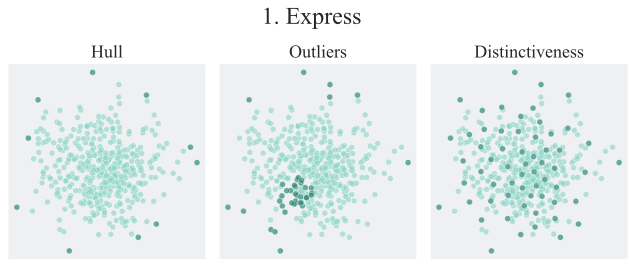

In [42]:
# Initialize color and plot settings
color = fss.plot.Color()
fss.plot.initialize(color)

# Plot the three different resulting subsets as scatterplots
titleSize = 24
subtitleSize = 18
titles = ["Hull", "Outliers", "Distinctiveness"]
subsets = [subsetHull, subsetOutliers, subsetDistinct]

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(9, 4))
fig.text(0.49, 1, '1. Express', ha='center', va='center', fontsize=titleSize)

for i, ax in enumerate(fig.axes):
    ax.grid(visible=False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(titles[i], fontsize=subtitleSize)
    ax.set_aspect("equal")

    fss.plot.scatter(ax = ax, 
                 color = color, 
                 dataset = dataset, 
                 subset = subsets[i], 
                 alpha = 0.6)

plt.savefig(f"../figures/{directory}/express.pdf", bbox_inches="tight")

## Blend

For visualizations with multiple criteria, objec- tives can be combined together to achieve more complicated outcomes. Multiple criteria can be balanced using the weight parameters to ensure the objectives apply to the subsets at desirable levels.

In [48]:
subsetSize = 80

# Use distribution and distinctiveness objectives
objectives = [fss.objective.earthMoversDistance, fss.objective.distinctiveness]

# Parameters of the distribution and distinctiveness objectives
parameters = [{"dataset": dataset.dataArray}, 
              {"solveArray": "distances", "selectBy": "matrix"}]
              
# Create the multicriterion loss function from the objectives and weight them
solver.loss = fss.MultiCriterion(objectives, parameters, weights=[1000, 0.1])

# Solve for the blended distribution and distinctiveness subset
subsetBlend1 = solver.solve(dataset, subsetSize=subsetSize, verbose=verbose)
subsetBlend1.save(f"{directory}/blend1Subset")

In [49]:
# Update the weights to provide less emphasis on the distribution objective
solver.loss = fss.MultiCriterion(objectives, parameters, weights=[10, 0.1])

# Solve for the blended distribution and distinctiveness subset
subsetBlend2 = solver.solve(dataset, subsetSize=subsetSize, verbose=verbose)
subsetBlend2.save(f"{directory}/blend2Subset")

In [50]:
# Update the weights to an even weight of the two objectives
solver.loss = fss.MultiCriterion(objectives, parameters, weights=[1, 1])

# Solve for the blended distribution and distinctiveness subset
subsetBlend3 = solver.solve(dataset, subsetSize=subsetSize, verbose=verbose)
subsetBlend3.save(f"{directory}/blend3Subset")

### Plot

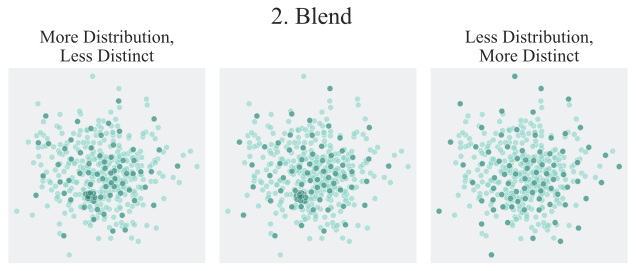

In [51]:
# Plot the three subsets with different blends of the two objectives
titles = ["More Distribution,\nLess Distinct", "", 
          "Less Distribution,\nMore Distinct"]
subsets = [subsetBlend1, subsetBlend2, subsetBlend3]

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(9, 4))
fig.text(0.49, 1, '2. Blend', ha='center', va='center', fontsize=titleSize)

for i, ax in enumerate(fig.axes):
    ax.grid(visible=False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(titles[i], fontsize=subtitleSize)
    ax.set_aspect("equal")

    fss.plot.scatter(ax = ax, 
                 color = color, 
                 dataset = dataset, 
                 subset = subsets[i], 
                 alpha = 0.6)

plt.savefig(f"../figures/{directory}/blend.pdf", bbox_inches="tight")

## Tune

Along with the weight parameters that help in blending objectives, the parameters of the objectives and the optimization formulation can be tuned to select a subset that is more effective for a given visualization. For example, the subset size, loss bounds, and subset weight parameters can be used to tune the subset size for a particular visualization. Objectives may have parameters associated with them such as the number of clusters in a clustering objective, the amount of seperation in a distinctiveness objective, or the smoothing parameter of a kernel density estimation. These provide additional flexibility to tune the objectives to a desirable level.

In [52]:
# Create a unicriterion loss function with the distinctiveness objective
solver.loss = fss.UniCriterion(objective = fss.objective.distinctiveness, 
                               solveArray = "distances",
                               selectBy = "matrix")
solver.algorithm = fss.algorithm.greedyMixed

# Solve for subsets with 3 different subset sizes
subsetDistinct1 = solver.solve(dataset=dataset, weight=0.5, initialSize=3)
subsetDistinct1.save(f"{directory}/distinct1Subset")

subsetDistinct2 = solver.solve(dataset=dataset, weight=0.25, initialSize=3)
subsetDistinct2.save(f"{directory}/distinct2Subset")

subsetDistinct3 = solver.solve(dataset=dataset, weight=0.1, initialSize=3)
subsetDistinct3.save(f"{directory}/distinct3Subset")

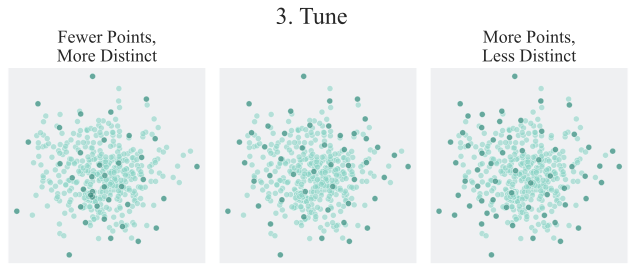

In [53]:
# Plot the three subsets with different subset sizes based on the tuning
titles = ["Fewer Points,\nMore Distinct", "", "More Points,\nLess Distinct"]
subsets = [subsetDistinct1, subsetDistinct2, subsetDistinct3]

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(9, 4))
fig.text(0.49, 1, '3. Tune', ha='center', va='center', fontsize=titleSize)

for i, ax in enumerate(fig.axes):
    ax.grid(visible=False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(titles[i], fontsize=subtitleSize)
    ax.set_aspect("equal")

    fss.plot.scatter(ax = ax, 
                 color = color, 
                 dataset = dataset, 
                 subset = subsets[i], 
                 alpha = 0.6)

plt.savefig(f"../figures/{directory}/tune.pdf", bbox_inches="tight")